In [12]:
import cml

vodafone_data = cml.VodafoneData()
vodafone_roads_df = vodafone_data.read('data/vodafone_main_roads/')
vodafone_data.preprocess(vodafone_roads_df)
columns = ['Grid_ID', 'Datetime', 'C1', 'C2', 'C11', 'E1', 'E7', 'E8', 'E9']
vodafone_roads_df = vodafone_roads_df[columns]
vodafone_roads_df.head()

,Grid_ID,Datetime,C1,C2,C11,E1,E7,E8,E9
0,16,2022-09-01 00:00:00+00:00,4.66,0.00,0.0,0.0,5.0,5.00,5.0
1,16,2022-09-01 00:05:00+00:00,9.55,1.81,0.0,0.0,0.0,1.25,5.0
2,16,2022-09-01 00:10:00+00:00,11.66,0.00,0.0,0.0,0.0,5.17,31.0
3,16,2022-09-01 00:15:00+00:00,15.79,1.78,0.0,0.0,0.0,4.25,29.0
4,16,2022-09-01 00:20:00+00:00,10.59,0.00,0.0,0.0,0.0,5.92,43.0


In [45]:
from matplotlib import colormaps as cm

def assign_street_name(grid_id):
    for street, grid_ids in cml.street_names.items():
        if grid_id in grid_ids:
            return street
    return None

def cmap_to_dict(cmap, categories):
    return {category: cmap(i) for category, i in zip(categories, np.linspace(0, 1, len(categories)))}

vodafone_roads_df['Street'] = vodafone_roads_df['Grid_ID'].apply(assign_street_name)
vodafone_roads_df['Street'] = vodafone_roads_df['Street'].astype('category')
vodafone_roads_df.set_index('Datetime', inplace=True)
vodafone_roads_resampled_df = vodafone_roads_df.groupby('Street').resample('10T').mean()
vodafone_roads_resampled_df.drop(columns=['Grid_ID'], inplace=True)
vodafone_roads_df.reset_index(inplace=True)
vodafone_roads_resampled_df.dropna(inplace=True)

streets_cmap_name = 'gist_rainbow'
streets_cmap = cm.get_cmap(streets_cmap_name)
streets_cmap_dict = cmap_to_dict(streets_cmap, vodafone_roads_df.Street.cat.categories)

vodafone_roads_resampled_df.head()

/tmp/ipykernel_17491/182242019.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vodafone_roads_resampled_df = vodafone_roads_df.groupby('Street').resample('10T').mean()


C1     C2    C11     E1   E7     E8  \
Street Datetime                                                              
A1     2022-05-01 00:00:00+00:00  162.665  5.785  2.035  0.000  0.0  6.230   
       2022-05-01 00:10:00+00:00  162.725  5.120  0.000  0.000  0.0  6.450   
       2022-05-01 00:20:00+00:00  182.475  6.580  4.170  0.000  0.0  5.740   
       2022-05-01 00:30:00+00:00  179.365  7.310  1.705  0.895  0.0  5.975   
       2022-05-01 00:40:00+00:00  206.130  5.110  0.000  0.000  0.0  6.520   

                                    E9  
Street Datetime                         
A1     2022-05-01 00:00:00+00:00  57.0  
       2022-05-01 00:10:00+00:00  65.0  
       2022-05-01 00:20:00+00:00  47.5  
       2022-05-01 00:30:00+00:00  45.5  
       2022-05-01 00:40:00+00:00  66.5

In [46]:
a1_df = vodafone_roads_resampled_df[vodafone_roads_resampled_df.index.isin(['A1'], level='Street')].copy()
a1_df.dropna(inplace=True)
a1_df.head()
a1_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20961 entries, ('A1', Timestamp('2022-05-01 00:00:00+0000', tz='UTC')) to ('A1', Timestamp('2022-10-31 23:50:00+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C1      20961 non-null  float64
 1   C2      20961 non-null  float64
 2   C11     20961 non-null  float64
 3   E1      20961 non-null  float64
 4   E7      20961 non-null  float64
 5   E8      20961 non-null  float64
 6   E9      20961 non-null  float64
dtypes: float64(7)
memory usage: 2.4 MB


In [91]:
from minisom import MiniSom

som_size = 15
som = MiniSom(som_size, som_size, len(a1_df.columns), sigma=1, learning_rate=2)
som.train(a1_df.values, 5000, verbose=True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 12.437493703925542


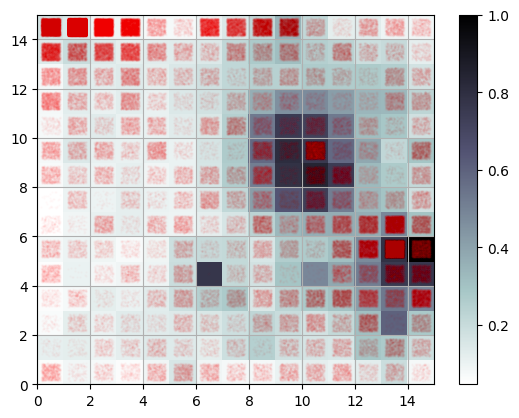

In [92]:
import matplotlib.pyplot as plt
import numpy as np

som_data = vodafone_roads_resampled_df.values
w_x, w_y = zip(*[som.winner(d) for d in som_data])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=1)
plt.colorbar()

plt.scatter(w_x + .5 + (np.random.rand(len(w_x)) - .5) * .7, 
            w_y + .5 + (np.random.rand(len(w_y)) - .5) * .7, 
            s=1, color='r', alpha=.01)

plt.grid()
plt.show()

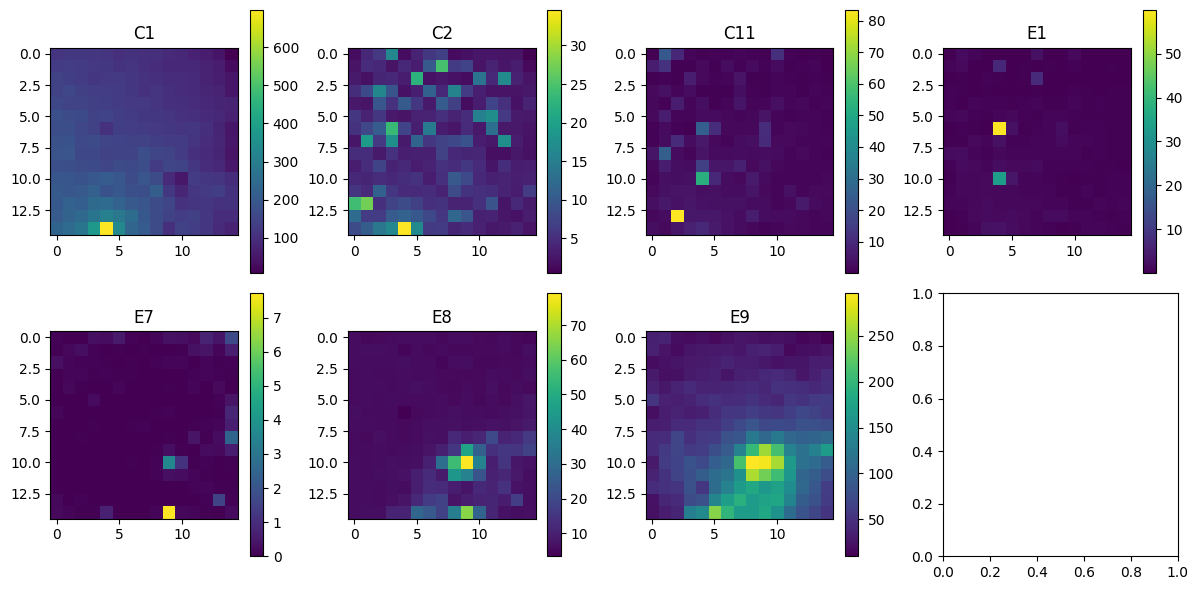

In [93]:
clustered_df = vodafone_roads_resampled_df.copy()
clustered_df['w_x'] = w_x
clustered_df['w_y'] = w_y
grouped_df = clustered_df.groupby(['w_x', 'w_y']).mean()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, col in zip(axes.flat, grouped_df.columns):
    ax.set_title(col)
    col_pivot = grouped_df[[col]].pivot_table(index='w_x', columns='w_y')
    col_pivot.fillna(0, inplace=True)
    im = ax.imshow(col_pivot.to_numpy())
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()